>[Part 2: DQN](#scrollTo=kDz_lNJMjLIL)

>[Part 3: Dueling DQN](#scrollTo=VXruYywge2Kp)



In [ ]:
!pip install gymnasium[classic-control]

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium.wrappers import RecordVideo, NormalizeObservation
from IPython.display import clear_output, display, HTML
from buffers import BasicBuffer
from models import DQN, DuelingDQN

In [ ]:
def plotter(x, y, label, title, lower_bound=None, upper_bound=None, window=30):
  weight = np.repeat(1.0, window)/window
  smas = np.convolve(y,weight,'valid')

  plt.figure(figsize=(8,6))
  plt.plot(x, y, label=label)
  plt.plot(smas, label=f"Moving Avg (window={window})")
  plt.fill_between(x, lower_bound, upper_bound, alpha=0.5, label=" 95% Confidence Interval")
  plt.xlabel("Episode")
  plt.ylabel(label)
  plt.title(title)
  plt.grid(True)
  plt.legend()
  plt.show()

In [ ]:
def mini_batch_train(env, agent, max_runs, max_episodes, max_steps, batch_size):

    runs_rewards = np.zeros((max_runs, max_episodes))

    for run in range(max_runs):
      agent.reset(epsilon = 1, learning_rate=3e-4, gamma=0.99, tau=0.005)

      for episode in range(max_episodes):
          state,_ = env.reset()
          episode_reward = 0

          for step in range(max_steps):
              action = agent.get_action(state)
              next_state, reward, terminated, truncated, _ = env.step(action)
              done = terminated or truncated
              agent.replay_buffer.push(state, action, reward, next_state, done)
              episode_reward += reward

              if len(agent.replay_buffer) > batch_size:
                  agent.update(batch_size)

              if done or step == max_steps-1:
                  agent.eps_decay()
                  runs_rewards[run, episode] = episode_reward
                  print(f"Run= {run+1}, Episode= {episode+1}, Episode Reward= {episode_reward}, Epsilon= {agent.eps}")
                  clear_output(wait=True)
                  break

              state = next_state
    env.close()
    return runs_rewards

# Part 2: DQN

In [ ]:
class DQNAgent:

    def __init__(self, env, buffer_size=10000):
        self.env = env

        self.replay_buffer = BasicBuffer(max_size=buffer_size)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.MSE_loss = nn.MSELoss()

    def reset(self, epsilon = 1, learning_rate=3e-4, gamma=0.99, tau=0.005):

        self.model = DQN(self.env.observation_space.shape, self.env.action_space.n).to(self.device)
        self.target_model = DQN(self.env.observation_space.shape, self.env.action_space.n).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())

        self.optimizer = torch.optim.Adam(self.model.parameters())

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.eps = epsilon
        self.tau = tau

    def get_action(self, state):
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
          qvals = self.model.forward(state)

        if np.random.randn() < self.eps:
            action = self.env.action_space.sample()
        else:
            action = torch.argmax(qvals)

        return action.item()

    def eps_decay(self, rate = 0.995):
        self.eps = max(self.eps * rate, 0.01)

    def compute_loss(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones)

        curr_Q = self.model.forward(states).gather(1, actions.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target_model.forward(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        expected_Q = rewards.squeeze(1) + self.gamma * max_next_Q

        loss = self.MSE_loss(curr_Q, expected_Q)
        return loss

    def update(self, batch_size):
        batch = self.replay_buffer.sample(batch_size)
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.model, self.target_model, self.tau)  # Soft update target model

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
MAX_RUNS = 4
MAX_EPISODES = 600
MAX_STEPS = 500
BATCH_SIZE = 128

env = gym.make('Acrobot-v1', render_mode="rgb_array")
trigger = lambda t: t % 280 == 0
env = RecordVideo(env, video_folder="./DQN", episode_trigger=trigger)
env = NormalizeObservation(env)

agent = DQNAgent(env)

In [ ]:
runs_rewards = mini_batch_train(env, agent, MAX_RUNS, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

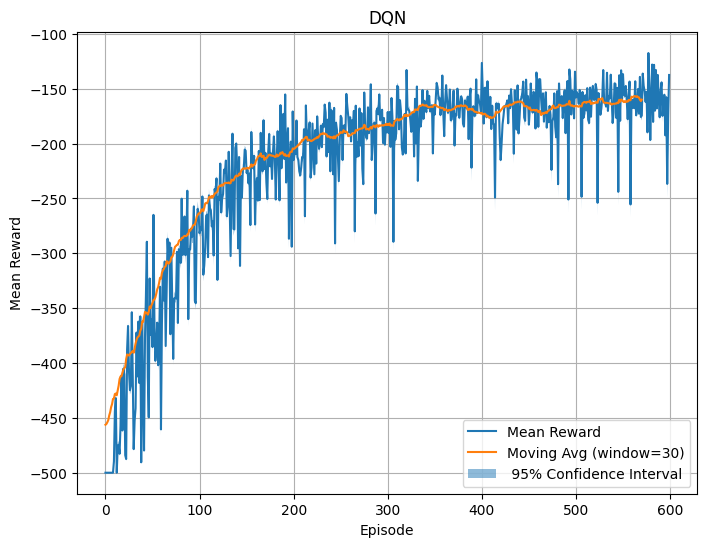

In [ ]:
mean_rewards = np.mean(runs_rewards, axis=0)
mean_rewards_std = np.std(runs_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","DQN", mean_reward_lbound, mean_reward_ubound)

# Part 3: Dueling DQN

In [ ]:
class DuelingAgent:

    def __init__(self, env, buffer_size=10000):
        self.env = env

        self.replay_buffer = BasicBuffer(max_size=buffer_size)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.MSE_loss = nn.MSELoss()

    def reset(self, epsilon=1, learning_rate=3e-4, gamma=0.99, tau=0.005):

        self.model = DuelingDQN(env.observation_space.shape, env.action_space.n).to(self.device)

        self.target_model = DuelingDQN(env.observation_space.shape, env.action_space.n).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())

        self.optimizer = torch.optim.Adam(self.model.parameters())

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.eps = epsilon
        self.tau = tau

    def get_action(self, state):
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
          qvals = self.model.forward(state)

        if np.random.randn() < self.eps:
            action = self.env.action_space.sample()
        else:
            action = torch.argmax(qvals)

        return action.item()

    def eps_decay(self, rate = 0.995) -> None:
        self.eps = max(self.eps * rate, 0.01)

    def compute_loss(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        curr_Q = self.model.forward(states).gather(1, actions.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target_model.forward(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        expected_Q = rewards.squeeze(1) + self.gamma * max_next_Q

        loss = self.MSE_loss(curr_Q, expected_Q)

        return loss

    def update(self, batch_size):

        batch = self.replay_buffer.sample(batch_size)
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.model, self.target_model, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
MAX_RUNS = 4
MAX_EPISODES = 600
MAX_STEPS = 500
BATCH_SIZE = 128

env = gym.make('Acrobot-v1', render_mode="rgb_array")
trigger = lambda t: t % 280 == 0
env = RecordVideo(env, video_folder="./DuelingDQN", episode_trigger=trigger)
env = NormalizeObservation(env)

agent = DuelingAgent(env)

In [ ]:
runs_rewards = mini_batch_train(env, agent, MAX_RUNS, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

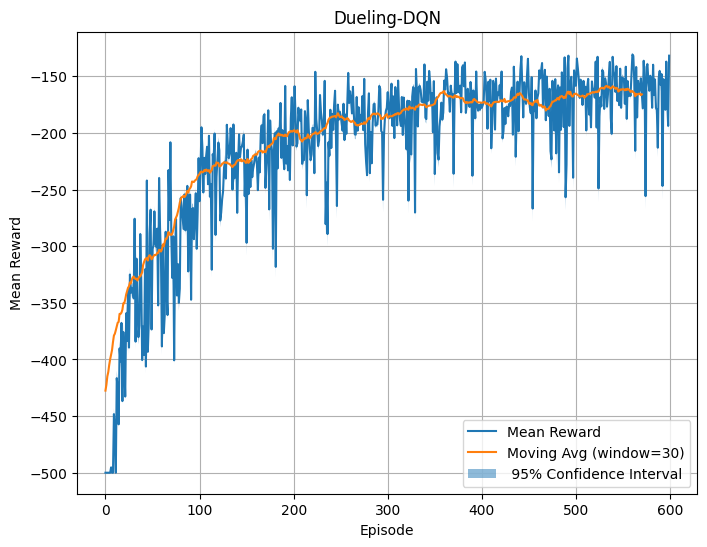

In [ ]:
mean_rewards = np.mean(runs_rewards, axis=0)
mean_rewards_std = np.std(runs_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Dueling-DQN", mean_reward_lbound, mean_reward_ubound)